In [1]:
!pip install gym_super_mario_bros==7.3.0 nes_py

     |████████████████████████████████| 198 kB 5.3 MB/s 
     |████████████████████████████████| 76 kB 4.8 MB/s 
  Created wheel for nes-py: filename=nes_py-8.1.8-cp37-cp37m-linux_x86_64.whl size=440257 sha256=4eff530a12e1276c99edfdc9af5d10dd9e904cef96e1fcb4288706c647eb1631
  Stored in directory: /root/.cache/pip/wheels/f2/05/1f/608f15ab43187096eb5f3087506419c2d9772e97000f3ba025
Successfully built nes-py


In [2]:
# Import the game
import gym_super_mario_bros
# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [3]:
SIMPLE_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

In [4]:
# Setup game
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [5]:
# # Create a flag - restart or not
# done = True
# # Loop through each frame in the game
# for step in range(100000): 
#     # Start the game to begin with 
#     if done: 
#         # Start the gamee
#         env.reset()
#     # Do random actions
#     state, reward, done, info = env.step(env.action_space.sample())
#     # Show the game on the screen
#     env.render()
# # Close the game
# env.close()

## Preprocess Environment

In [6]:
# # Install pytorch
!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html


Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
     |██████████████▋                 | 834.1 MB 1.3 MB/s eta 0:12:43tcmalloc: large alloc 1147494400 bytes == 0x55ab7b0f6000 @  0x7f241669e615 0x55ab417023bc 0x55ab417e318a 0x55ab417051cd 0x55ab417f7b3d 0x55ab41779458 0x55ab4177402f 0x55ab41706aba 0x55ab417792c0 0x55ab4177402f 0x55ab41706aba 0x55ab41775cd4 0x55ab417f8986 0x55ab41775350 0x55ab417f8986 0x55ab41775350 0x55ab417f8986 0x55ab41775350 0x55ab41706f19 0x55ab4174aa79 0x55ab41705b32 0x55ab417791dd 0x55ab4177402f 0x55ab41706aba 0x55ab41775cd4 0x55ab4177402f 0x55ab41706aba 0x55ab41774eae 0x55ab417069da 0x55ab41775108 0x55ab4177402f
     |██████████████████▌             | 1055.7 MB 1.4 MB/s eta 0:09:02tcmalloc: large alloc 1434370048 bytes == 0x55abbf74c000 @  0x7f241669e615 0x55ab417023bc 0x55ab417e318a 0x55ab417051cd 0x55ab417f7b3d 0x55ab41779458 0x55ab4177402f 0x55ab41706aba 0x55ab417792c0 0x55ab4177402f 0x55ab41706aba 0x55ab41775cd4 0x55ab417f8986 0x55ab

In [7]:
# # Install stable baselines for RL stuff
!pip install stable-baselines3[extra]

     |████████████████████████████████| 176 kB 5.5 MB/s 
     |████████████████████████████████| 2.8 MB 57.0 MB/s 
Reason for being yanked: re-release with new wheels
  Attempting uninstall: atari-py
    Found existing installation: atari-py 0.2.9
    Uninstalling atari-py-0.2.9:
      Successfully uninstalled atari-py-0.2.9


In [6]:
# Import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# Import Matplotlib to show the impact of frame stacking
from matplotlib import pyplot as plt

In [7]:
# 1. Create the base environment
env = gym_super_mario_bros.make('SuperMarioBros-v0')
# 2. Simplify the controls 
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# 3. Grayscale
env = GrayScaleObservation(env, keep_dim=True)
# 4. Wrap inside the Dummy Environment
env = DummyVecEnv([lambda: env])
# 5. Stack the frames
env = VecFrameStack(env, 4, channels_order='last')

In [8]:
state = env.reset()

In [9]:
state, reward, done, info = env.step([5])

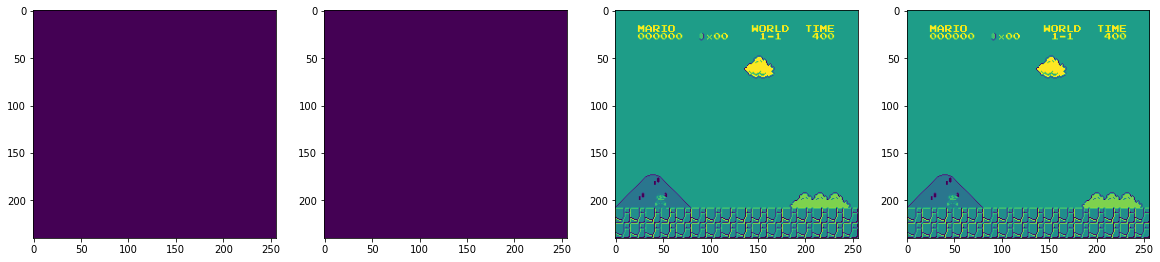

In [10]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

## Train the RL Model

In [13]:
# Import os for file path management
import os 
# Import PPO for algos
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [14]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [15]:
CHECKPOINT_DIR = '/content/drive/MyDrive/train/'
LOG_DIR = '/content/drive/MyDrive/logs/'

In [16]:
# Setup model saving callback
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)


In [17]:
# This is the AI model started
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, 
            n_steps=512) 

Using cpu device
Wrapping the env in a VecTransposeImage.


In [18]:
# Train the AI model, this is where the AI model starts to learn
model.learn(total_timesteps=1000000, callback=callback)

Logging to /content/drive/MyDrive/logs/PPO_2


/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


----------------------------
| time/              |     |
|    fps             | 21  |
|    iterations      | 1   |
|    time_elapsed    | 23  |
|    total_timesteps | 512 |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 7            |
|    iterations           | 2            |
|    time_elapsed         | 141          |
|    total_timesteps      | 1024         |
| train/                  |              |
|    approx_kl            | 0.0001225986 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.95        |
|    explained_variance   | -2.01e-05    |
|    learning_rate        | 1e-06        |
|    loss                 | 84           |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.000686    |
|    value_loss           | 261          |
------------------------------------------
-----------------------

KeyboardInterrupt: ignored

## Test it Out

In [18]:
# Load model
model = PPO.load('/content/drive/MyDrive/train/best_model_50000')

In [19]:
state = env.reset()

In [20]:
SIMPLE_MOVEMENT[model.predict(state)[0][0]]

['NOOP']

In [21]:
# !pip install pyglet

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
from matplotlib.pyplot import figure

figure(figsize=(80, 60), dpi=80)

<Figure size 6400x4800 with 0 Axes>

<Figure size 6400x4800 with 0 Axes>

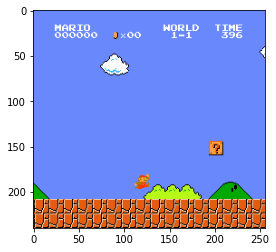

In [23]:
# Start the game 
state = env.reset()
# Loop through the game
img = plt.imshow(env.render('rgb_array')) # only call this once
step = 0
while step<100: 
    img.set_data(env.render('rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    step+=1
    # show_state(env, info)
    # plt.imshow(env.render(mode='rgb_array'))
env.close()

    